# Portfolio optimization

Portfolio optimization is the problem related to financial services and banking industry that emerged with Markovitz's seminal paper in 1952. The model describes a set of assets $x_i \in \{X\}_n$ from which a subset needs to be picked trying to maximize the revenue while minimizing the risk at $t$ future time steps. Each asset has associated a revenue forecast at a given time period ($e_i$) and the covariance between assets ($c_{ij}$) sets the risk amount in terms of diversification (for the sake of simplicity). The idea behind this diversification is that if we would only invest in the assets with highest revenue, the risk of them being driven by the same factors if our investment fails is bigger than if we diversify our portfolio. We will focus on a single time step process assuming local optima are part of the longer time step trajectory towards the global optima of our portfolio.

Lets consider then, a single time step optimization for the sake of simplicity. Investment comes at a cost. A budget ($B$) is associated to the investment on a portfolio configuration and described by the summation cost of investing on each asset as $b_i$, where $i$ is the index of the particular asset. Ideally our recommendation should not surpass this condition ($\sum b_i < B$). Hence, this classical optimization problem is often posed as 

$$
\displaystyle \max_{x_{i}\in{\{0,1\}}} \sum_{i=1}^{n} x_{i}e_i -\;\theta \sum_{i,j=1}^{n}x_{i}x_{j}c_{ij}\\
\textrm{s.t.} \sum_{i=1}^{n}x_{i}b_{i} \leq B, \\
$$

where $x_{i}\in{\{0,1\}}$ is the mask associated to the selection of our set of assets and $\theta$ is a Lagrangian operator modulating the amount of risk we would like to assume. We have binarized this selection as it simplifies the calculation but of course, more comples portfolio investments can be considered tackling those three aspects on the model (revenue, risk and budget).

We will look for the minimization of that very same model as it will fit better the technical approach we will follow. Thus the final model would look like:

$$
\displaystyle \min_{x_{i}\in{\{0,1\}}} - \sum_{i=1}^{n} x_{i}e_i + \;\theta \sum_{i,j=1}^{n}x_{i}x_{j}c_{ij}\\
\textrm{s.t.} \sum_{i=1}^{n}x_{i}b_{i} \leq B, \\
$$

Lets load our existing data and build that optimization problem.

In [9]:
import json

data = None
with open("binance-data.json", "r") as jsonfile:
    data = json.load(jsonfile)

In [10]:
import numpy as np

returns = data['mu']
covar = data['sigma']

assets = []
costs = []
for row in data['assets']:
    assets.append(row["Asset"])
    costs.append(float(row["Open"]))

# Half the money
budget = np.sum(costs)/0.5

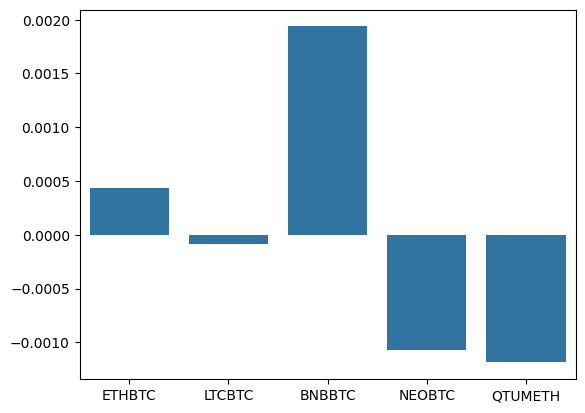

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(y=returns, x = assets)
plt.show()

We will use CVX and its Python implementation (cvxpy) with a mixed integer optimization approach as our problem is restricted by the boolean values our $x$ variables can take, created for convex optimization; itself isn't a solver, it is a modeling framework

In [12]:
import cvxpy as cp
import numpy 

# Our solution variable
x_val = cp.Variable(len(returns), boolean=True)
theta = cp.Parameter(nonneg=True)
ret = np.array(returns)@x_val
risk = cp.quad_form(x_val, covar)
e_costs = np.array(costs)@x_val

# Constraints
cons = [cp.sum(x_val) >= 0, cp.sum(e_costs) <= budget, x_val >= 0]

# Objective function
obj = cp.Minimize(- ret + theta*risk)

# Problem
prob = cp.Problem(obj, cons)

In [16]:
%%time
import csv
import time
import pandas as pd
i = 0
with open('cvxpy5.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ['number of asset',"iteration", "time"]
    writer.writerow(field)
    while i<1000:
        i = i + 1
        start = time.process_time()
        theta.value = 0.03 # This is related to the risk penalty lagrangian
        prob.solve(solver='ECOS_BB')
        end = time.process_time()
        writer.writerow([5, i, end-start])
data1 = pd.read_csv('cvxpy5.csv')
print(data1['time'].mean())
print(data1['time'].std())

0.0011274569999999828
0.00038435621218983355
CPU times: user 1.1 s, sys: 40.7 ms, total: 1.14 s
Wall time: 1.16 s


In [ ]:
for i, val in enumerate(np.round(x_val.value,1)):
    if val == 1:
        print(f"Asset {assets[i]} was selected")
    else:
        print(f"Asset {assets[i]} was not selected")

Asset ETHBTC was selected
Asset LTCBTC was not selected
Asset BNBBTC was selected
Asset NEOBTC was not selected
Asset QTUMETH was not selected
